# Full functional implementation

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Literal

# determing how many subpixels per grid cell
def step_size(n = 10):
    steps = [s/100 for s in range(0, 101, n)]
    return steps

# smoother/fader function
def smootherstep(x):
    return 6*(x**5) - 15*(x**4) + 10*(x**3)



def make_gradient_vectors(overall_size, random_state):
    # default vectors for 2 dimensions in 8 axes
    default_vectors = [(1, 1), (-1, 1), (-1, -1), (1, -1)
                    , (np.sqrt(2), 0), (0, np.sqrt(2)), (-np.sqrt(2), 0), (0, -np.sqrt(2))
                    ]
    
    rng = np.random.default_rng(seed = random_state)
    gradient_vectors = [[a for a in rng.choice(default_vectors, overall_size)] for _ in range(overall_size)]

    # normalize lengths
    gradient_vectors = [[vec / np.dot(vec, vec) for vec in row] for row in gradient_vectors]

    return gradient_vectors



def perlin_noise(overall_size = 10, resolution: Literal[1, 5, 10, 20, 25, 50] = 25, plot = True, random_state = 42):
    """
    Inputs:
    
    overall_size: an N by N grid defining the number of gradient vectors to use

    resolution: a step size for how well defined you want the noise to look
        
    * choose a value from [1, 5, 10, 20, 25, 50]

    plot: True or False to display the plot

    random_state: random value to make the noise

    Outputs:

    A heatmap of the generated noise

    """
    gradient_vectors = make_gradient_vectors(overall_size, random_state)

    steppings = np.array(step_size(n = resolution))

    noise = []

    # N is the grid size dimension
    N = overall_size - 1

    # M is the subgrid size dimension
    M = len(steppings)

    # loop through all pixels in the image
    for i in range((N*M)):
        for j in range((N*M)):

            # determining pixel position
            x, y = i, j
            current_point = np.array([x, y])

            cell_width, cell_height = M, M

            cell_x_index = int(np.floor(x/cell_width))
            cell_y_index = int(np.floor(y/cell_height))

            cell_x_origin = int(cell_x_index * cell_width)
            cell_y_origin = int(cell_y_index * cell_height)
            
            # fractional coordinates 
            xf, yf = [(x - cell_x_origin)/cell_width, (y - cell_y_origin)/cell_width]

            # smoothed fractional coordinates
            u, v = smootherstep(xf), smootherstep(yf)

            # determining each corner based on the current pixel
            ulc = np.array([cell_x_index * cell_width, cell_y_index * cell_height])
            urc = np.array([(cell_x_index+1) * cell_width, cell_y_index * cell_height])
            llc = np.array([cell_x_index * cell_width, (cell_y_index+1) * cell_height])
            lrc = np.array([(cell_x_index+1) * cell_width, (cell_y_index+1) * cell_height])
            
            # determing the appropriate gradient vector for the current pixel
            ul = gradient_vectors[cell_x_index][cell_y_index]
            ur = gradient_vectors[cell_x_index + 1][cell_y_index]
            ll = gradient_vectors[cell_x_index][cell_y_index + 1]
            lr = gradient_vectors[cell_x_index + 1][cell_y_index + 1]

            # determining offset vector
            oul = current_point - ulc
            our = current_point - urc
            oll = current_point - llc
            olr = current_point - lrc

            # calculating dot product between each corner and the offset
            dul = np.dot(ul, oul)
            dur = np.dot(ur, our)
            dll = np.dot(ll, oll)
            dlr = np.dot(lr, olr)

            # interpolating dot products
            # horizontally
            top_x_interpolate = (1 - u) * dul + u * dur
            bottom_x_interpolate = (1 - u) * dll + u * dlr

            # vertically / final result
            y_interpolate = (1 - v) * top_x_interpolate + v * bottom_x_interpolate
            noise.append(y_interpolate)

    noise = np.reshape(noise, (N*M, N*M))

    if plot:
        plt.figure(figsize=(10, 10))
        sns.heatmap(noise, cmap = 'gray', cbar = False)
        plt.axis('off')
        plt.show()


## Run this with what you want!

Here are two examples of mine

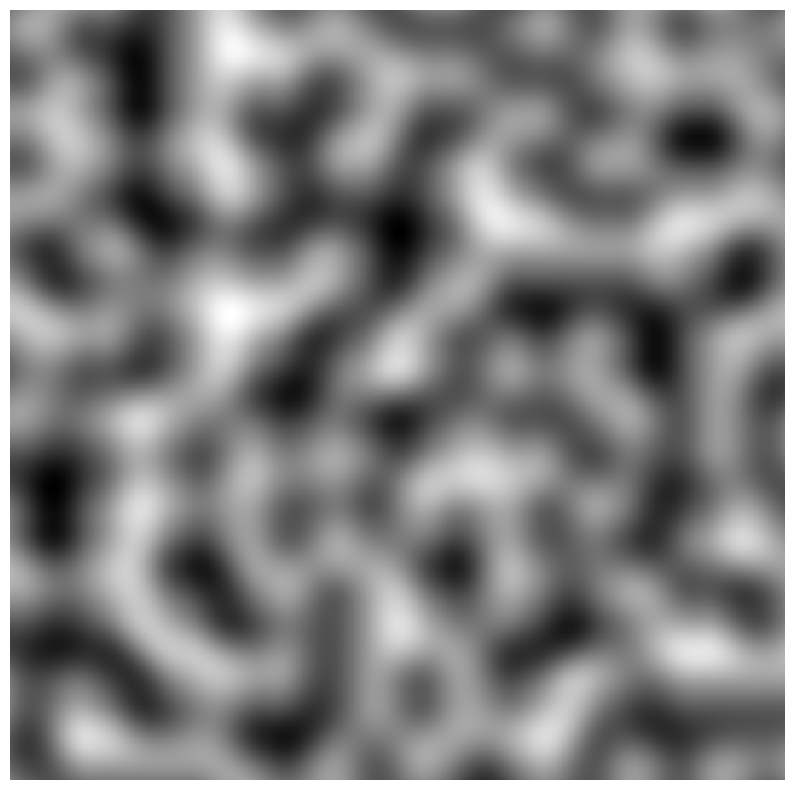

In [2]:
perlin_noise(resolution= 1, random_state = 42)

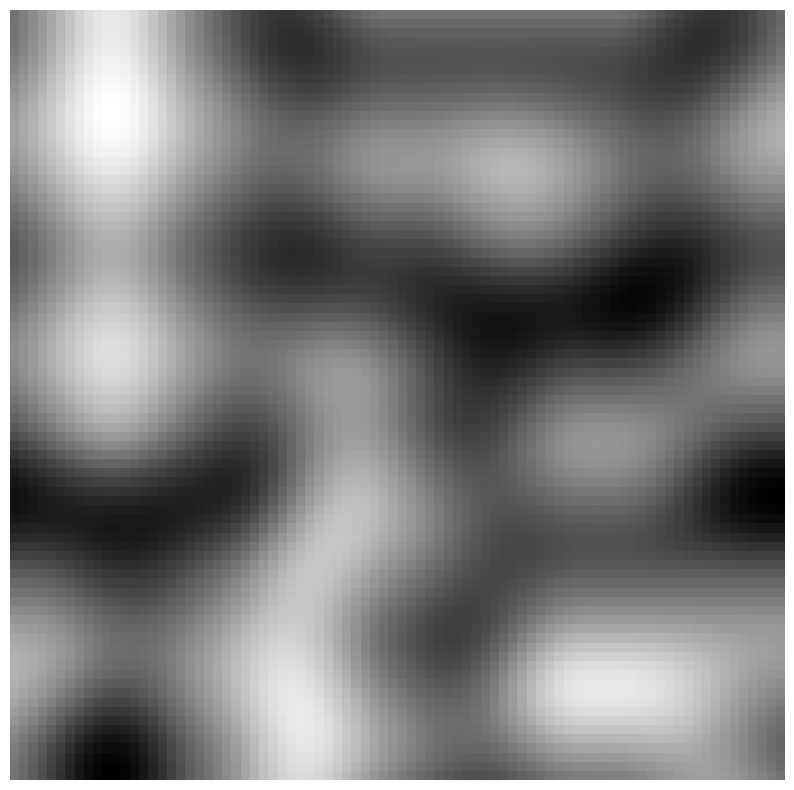

In [3]:
perlin_noise(overall_size = 5, resolution = 5, plot = True, random_state = 41)

---
# 1D Case

Truthfully, I made this in the middle of attempting the two dimensional case and found it quite easy and motivating to keep working.

In [4]:
import numpy as np

generate_amount = 10000

np.random.seed(1019)
terrain = np.random.uniform(-1, 1, size = generate_amount)

# it becomes incredibly noisy if you don't limit to just a small window of the data
# I generated a lot samples, use this as a sliding window of where you want to look
start = 0
stop = 10

terrain[start:stop]

array([-0.35216137, -0.76465501, -0.98839154,  0.7225985 ,  0.5689111 ,
       -0.58796111, -0.38744402, -0.42133744, -0.58634043, -0.74308708])

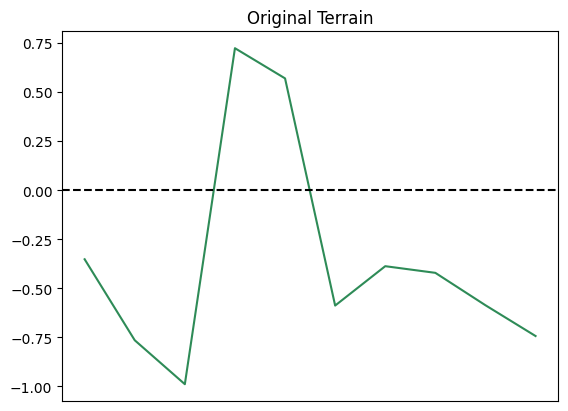

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(terrain[0:stop], color = "seagreen")
plt.axhline(y = 0, linestyle = 'dashed', color = 'black')
plt.title("Original Terrain")
plt.xticks([])
plt.show()

The dashed line is to indicate `y = 0` to help keep the context of the line changes between the original and the smoothed version.

I label this terrain, as you can think about this as a cross section of a game when a little character is surounting the peaks and valleys of this plot as mountains.

## Now interpolate it

In [6]:
smoothed = []

steps = step_size(n = 1)

for i in range(len(terrain) - 1):
    a0 = terrain[i]
    a1 = terrain[i + 1]
    
    for j in range(len(steps)):
        m = a0 + smootherstep(steps[j]) * (a1 - a0)

        smoothed.append(m)

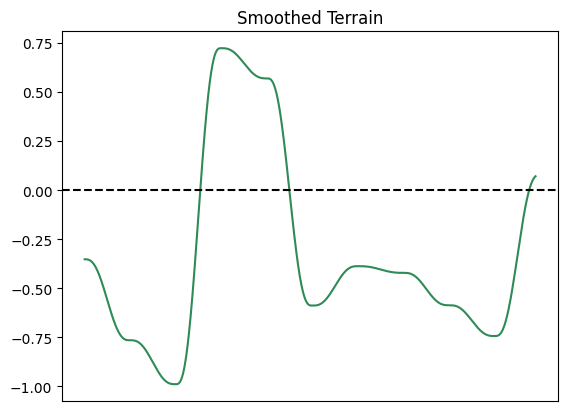

In [7]:
start_amount_smoothed = start * (len(steps) - 1)
stop_amount_smoothed = stop * (len(steps) - 1)

sns.lineplot(smoothed[start_amount_smoothed:stop_amount_smoothed], color = "seagreen")
plt.axhline(y = 0, linestyle = 'dashed', color = 'black')
plt.xticks([])
plt.title("Smoothed Terrain")
plt.show()

---
# Initial attempts

I started with just understanding the problem in three steps

* make gradient vectors
* calculate dot products between each gradient vector and offset vectors within each grid cell
* bilinearly interpolate them


So, I thought I could be clever and efficient and do the calculations ahead of time and then combine them all together at the end. 

That did not work.

In [8]:
import numpy as np

default_vectors = [(1, 1), (-1, 1), (-1, -1), (1, -1)
                   , (np.sqrt(2), 0), (0, np.sqrt(2)), (-np.sqrt(2), 0), (0, -np.sqrt(2))
                   ]

In [9]:
np.random.seed(1019)
rng = np.random.default_rng()
original_size = 10
gradient_vectors = [[a for a in rng.choice(default_vectors, original_size)] for _ in range(original_size)]

# normalize lengths
gradient_vectors = [[vec / np.dot(vec, vec) for vec in row] for row in gradient_vectors]

In [10]:
all_boxes = []

for i in range(len(gradient_vectors) - 1):
    for j in range(len(gradient_vectors[i]) - 1):
        ul, ur = gradient_vectors[i][j:j+2]
        ll, lr = gradient_vectors[i+1][j:j+2]


        all_boxes.append(np.array(ul))
        all_boxes.append(np.array(ur))
        all_boxes.append(np.array(ll))
        all_boxes.append(np.array(lr))

len(all_boxes)

324

In [11]:
def interpolating_steps(n = 10):

    steps = [s/100 for s in range(0, 101, n)]

    return steps

In [12]:
steppings = interpolating_steps(n = 25)
steppings = np.array(steppings)

def make_offset_vectors(steps):
    # Top left
    ul = [np.array([steps[i], steps[j]]) for i in range(len(steps)) for j in range(len(steps))]

    # Top right
    ur = [(steps[j]-1, steps[i]) for i in range(len(steps)) for j in range(len(steps))]

    # Bottom left
    ll = [(steps[j], steps[i]-1) for i in range(len(steps)) for j in range(len(steps))]

    # Bottom right
    lr = [(steps[j]-1, steps[i]-1) for i in range(len(steps)) for j in range(len(steps))]

    return (ul, ur, ll, lr)

box_upper_left, box_upper_right, box_lower_left, box_lower_right = make_offset_vectors(steppings)

In [13]:
all_meshes = []

for i in range(len(all_boxes)):
    for j in range(len(box_upper_left)):
        if i % 4 == 0:
            all_meshes.append(np.dot(all_boxes[i], box_upper_left[j]))
        elif i % 4 == 1:
            all_meshes.append(np.dot(all_boxes[i], box_upper_right[j]))
        elif i % 4 == 2:
            all_meshes.append(np.dot(all_boxes[i], box_lower_left[j]))
        else:
            all_meshes.append(np.dot(all_boxes[i], box_lower_right[j]))

all_dps = np.reshape(all_meshes, (len(all_boxes), len(steppings), len(steppings)))

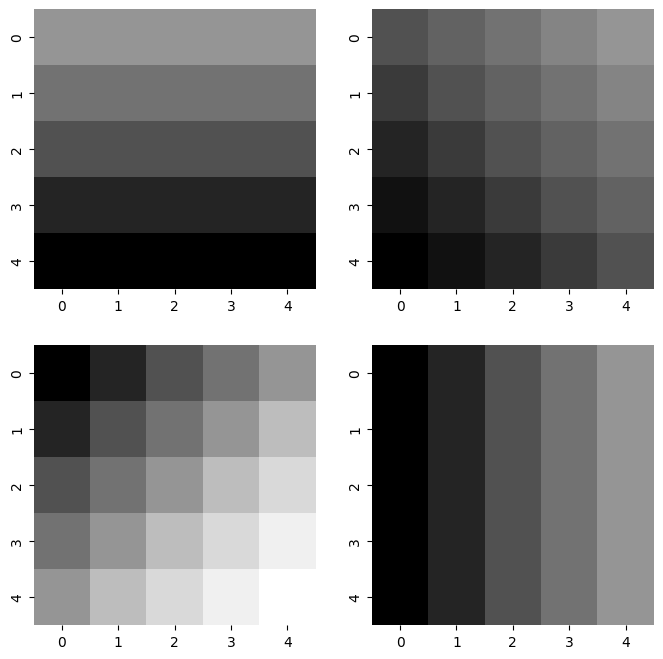

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

palette = sns.diverging_palette(220, 20, as_cmap=True)

bl = all_dps[:4]

for i, ax in enumerate(axes.flat):
    sns.heatmap(
        bl[i].reshape(len(steppings), len(steppings)), 
        ax = ax,
        # cmap=palette,
        cmap="Greys", vmin=all_dps[:4][i].min().min(), vmax=all_dps[:4][i].max().max(),
        annot=False,
        center=0, 
        cbar = False

    )


plt.show()

I truly thought I could then find a way to mix these together at each individual square and then composite the whole image together

In [15]:
def smootherstep(x):
    return 6*(x**5) - 15*(x**4) + 10*(x**3)

smooth_steps = smootherstep(steppings)

In [16]:
final_boxes = []

for i in range(len(all_dps)):
    if i % 4 == 0:
        R1 = (1-smooth_steps)*all_dps[i] + (smooth_steps*all_dps[i+1])
        R2 = (1-smooth_steps)*all_dps[i+2] + (smooth_steps*all_dps[i+3])

        res = (1 - smooth_steps) * (R1) + smooth_steps * (R2)
        res2 = (1 - smooth_steps) * np.transpose(R1) + smooth_steps * np.transpose(R2)

        final_boxes.append(res)

final_boxes = np.array(final_boxes)

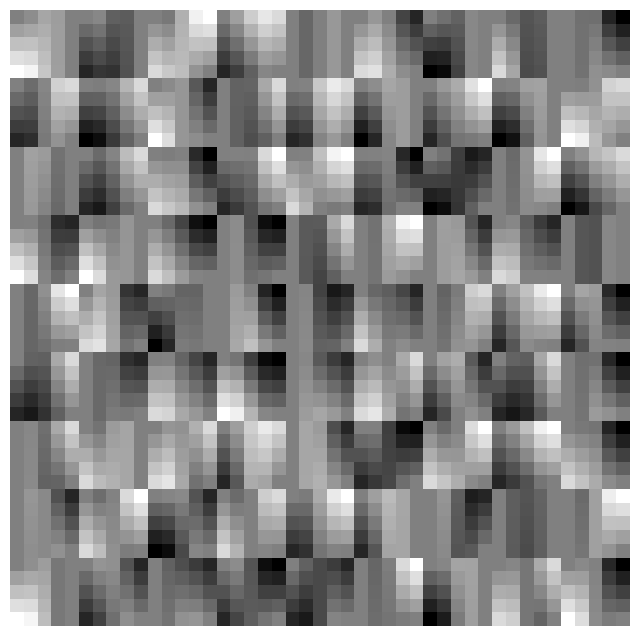

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

M = original_size - 1
N = len(steppings)

mosaic = np.zeros((M * N, M * N))

for i in range(M):
    for j in range(M):
        mosaic[i*N:(i+1)*N, j*N:(j+1)*N] = final_boxes[i*M + j]

# Visualization
plt.figure(figsize=(8, 8))
sns.heatmap(mosaic, cbar = False, cmap = "gray")
plt.axis('off')
plt.show()

As you can see, it did not work. It's hard to tell but if you turn the resolution up for this method, I have sharp edges between each grid cell. 

I was treating each grid cell independently and not understanding that I needed to have the whole image in mind as I made the noise.

---
# Finally figuring it out

In [18]:
# noise = []

# def smootherstep(x):
#     return 6*(x**5) - 15*(x**4) + 10*(x**3)

# steppings = np.array(interpolating_steps(n = 1))
# smooth_steps = smootherstep(steppings)

# N = original_size - 1
# M = len(smooth_steps)

# for i in range((N*M)):
#     for j in range((N*M)):

#         # determining pixel position
#         x, y = i, j
#         current_point = np.array([x, y])

#         cell_width, cell_height = M, M

#         cell_x_index = int(np.floor(x/cell_width))
#         cell_y_index = int(np.floor(y/cell_height))

#         # print(cell_x_index, cell_y_index)

#         cell_x_origin = int(cell_x_index * cell_width)
#         cell_y_origin = int(cell_y_index * cell_height)

#         # print(cell_x_origin, cell_y_origin)

#         # print(x, y)
        
#         xf, yf = [(x - cell_x_origin)/cell_width, (y - cell_y_origin)/cell_width]
#         u, v = smootherstep(xf), smootherstep(yf)

#         # calculating dot product
#         ulc = np.array([cell_x_index * cell_width, cell_y_index * cell_height])
#         urc = np.array([(cell_x_index+1) * cell_width, cell_y_index * cell_height])
#         llc = np.array([cell_x_index * cell_width, (cell_y_index+1) * cell_height])
#         lrc = np.array([(cell_x_index+1) * cell_width, (cell_y_index+1) * cell_height])

#         ul = gradient_vectors[cell_x_index][cell_y_index]
#         ur = gradient_vectors[cell_x_index + 1][cell_y_index]
#         ll = gradient_vectors[cell_x_index][cell_y_index + 1]
#         lr = gradient_vectors[cell_x_index + 1][cell_y_index + 1]


#         # print(ulc, urc, llc, lrc)
#         oul = current_point - ulc
#         our = current_point - urc
#         oll = current_point - llc
#         olr = current_point - lrc

#         dul = np.dot(ul, oul)
#         dur = np.dot(ur, our)
#         dll = np.dot(ll, oll)
#         dlr = np.dot(lr, olr)

#         # print(dul, dur, dll, dlr)

#         # interpolation
#         top_x_interpolate = (1 - u) * dul + u * dur
#         bottom_x_interpolate = (1 - u) * dll + u * dlr

#         y_interpolate = (1 - v) * top_x_interpolate + v * bottom_x_interpolate

#         # print(y_interpolate)

#         noise.append(y_interpolate)

       
#         # print("-"*100)

# noise = np.reshape(noise, (N*M, N*M))

In [19]:
# import matplotlib.pyplot as plt
# import seaborn as sns


# # plt.figure(figsize=(12, 12))
# plt.matshow(noise, cmap='gray') 
# plt.xticks([])
# plt.yticks([])
# plt.show()